# Rotation Solution August 2023 Update

The rotation solution using the VQF library is currently in a state where the orientations obtained are acceptable with a high level of confidence.
Discussion with Supracon, however, indicates that we need the velocity of the bird in order to remove self-inductance effects from the signal.
This has led to a few problems:
* velocity provided by the GPS system does not provide improved results when used with the Supracon motion noise compensation
* velocity obtained through rotation of the accelerometer data, high passed to remove gravity and integrated does not provide improved results when used with Supracon motion noise compensation
* old Kalman filter takes days to run, and only provides velocities at GPS resolution. Additionally, the orientations returned by this solution are very notably incorrect

I am at a point now where I think having more eyes on what is happening would be beneficial, as I do not know if the error in the methodology is at the calculation of the velocities or at the application of the Supracon motion noise compensation.

The following is a rundown of the code as it exists right now.
This analysis is done with the Namibia data set.

## Orientation Issues

One of the biggest issues at this time is the issue of what the orientation of the data from the IMU is supposed to be in.
{ref}`uimu_axes` shows the datasheet orientations.
According to a conversation held with Markus, for the Namibia flight the data of index 0 corresponds to the Y axis of the IMU, index 1 to the Z axis of the IMU and index 2 to the X axis.
This is where the confusion begins, especially since the Namibia flight makes use of the fogIMU, which we don't know whether or not the orientation is the same.

```{figure} ./Figures_for_documents/aug2023_rotation_update/uimu_axis_labels.png
:name: uimu_axes
:align: center
The axes orientations from the uimu datasheet.
```

Pictures of the bird indicate that the flat edge runs parallel with the length of the bird, and the bit that sticks out is pressed against the body of the bird.
The indication is then that the X-axis of the uimu should be aligned with our vertical, the Y-axis with our longitudinal direction, and the Z-axis aligned with the lateral direction, 90 degrees to the right of the Y-axis.

The takeaway here is that in our code, after reading in the raw data we want longitudinal to be along axis index 0, lateral along index 1 and vertical with index 2.

It was only recently found, after a mis-match between lateral and longitudinal PSD results between myself and Markus that it was found that the X-axis was being assigned to vertical, Z-axis to longitudinal and Y-axis to lateral.
Again, because the fogIMU and the ```*.gyro``` files may not have the same orientation, I am unsure what may need to be changed with the Namibia dataset, but visual inspection seems to indicate that we do have longitudinal being saved to 0, lateral to 1 and vertical to 2.

## Pre-rotated Data

Not much to say here, {ref}`pre_rot` is what the data looks like pre-rotation (only for the 5 flight lines):
``` {figure} ./Figures_for_documents/aug2023_rotation_update/SQUID_notRotated.png
:name: pre_rot
:width: 500
Namibia dataset pre rotation SQUID data, raw from the fluxjump correction step.
```

## Existing Process

The process for the rotation solution is currently to pass the gyroscope, accelerometer and fluxgate magnetometer data to the [VQF method](https://arxiv.org/pdf/2203.17024.pdf).
This generates an orientation of the imu in the East-North-Up (ENU) convention, which is easy enough to change to the North-East-Down (NED) convention.
It is also worth noting that VQF creates orientations with respect to magnetic north, not geographic north, so an additional correction is used with the International Geomagnetic Reference Field (IGRF) that is determined from GPS positions.

{ref}`Namibia_gps` shows the Namibia flight lines, with the direction of the flight marked with arrows:
```{figure} ./Figures_for_documents/aug2023_rotation_update/Namibia_flight_GPS_wDir.png
:name: Namibia_gps
:width: 500
GPS data for the Namibia flight, showing the flight path with directions.
```
    
The quaternions generated from this method take data that is in the BIRD (or BODY) reference frame and translates it to the NED convention.
These quaternions can also be used in a "reverse" method to take measurements from NED convention to BODY as well.
In {ref}`quaternion_result` the mathematically more useful representation of the orientation can be seen, while {ref}`euler_representation` shows the Euler angles which make more visual sense.

```{figure} ./Figures_for_documents/aug2023_rotation_update/Quaternions.png
:name: quaternion_result
:width: 500
The quaternion representation of the Namibia rotation solution. Note that this result is an outdated result of un-tuned VQF parameters.
```

```{figure} ./Figures_for_documents/aug2023_rotation_update/EulerAngleVersion.png
:name: euler_representation
:width: 700
The Euler angle representation of the Namibia rotation solution. Note that this result is an outdated result of un-tuned VQF parameters.
```
At this point, the IGRF is determined for the flight, and the orientations are used to rotate the IGRF into the BODY frame.

Here is the IGRF in the NED frame (altogether and then separate):

```{figure} ./Figures_for_documents/aug2023_rotation_update/IGRF_far.png
:name: IGRF_all
:width: 500
The IGRF field for the Namibia flight, showing the North, East and Down components on the same scale.
```
```{figure} ./Figures_for_documents/aug2023_rotation_update/IGRF_close.png
:name: IGRF_sep
:width: 500
The IGRF fields for the Namibia flight, North, East and Down, separated into their own scale.
```
```{figure} ./Figures_for_documents/aug2023_rotation_update/IGRF_bird.png
:name: IGRF_bird
:width: 500
The IGRF field after being rotated into the reference frame of the bird.
```

From here, the SQUID data is rotated, scaled and shifted via the Procrustes method to align with the IGRF data.

```{figure} ./Figures_for_documents/aug2023_rotation_update/SQUID_post_procrustes.png
:name: squid_post_procrustes
:width: 500
The SQUID data after application of the Procrustes method.
```

In the normal case, where no extra steps are done, this is then rotated via quaternions from the BODY frame to NED convention:

```{figure} ./Figures_for_documents/aug2023_rotation_update/SQUID_post_rotation.png
:name: squid_rotated
:width: 500
No additional steps, after Procrustes application the SQUID data is rotated back into NED frame from the bird frame.
```

This result looks reasonable, but has very high noise.
The most probable reason for this noise is the "motion noise compensation" step that is normally done by Supracon, which removes eddy current and self-induction effects, is not done in this version of the analysis.


## Supracon Process

Without having full access to the Supracon MATLAB code, the details of how Supracon does this correction are a bit cryptic.
After a few conversations with Markus however, we were given the following information:


$M = \hat{S}\hat{D}_{dist}\hat{R}[(I + \hat{T})B + \hat{C}(v \times B)] + o$

Fit of parameters on entire decimated dataset (1kHz):
1. scalar calibration (three misalignment angles, three sensitivities, three offsets) [From Schiffler et al 2014](https://academic.oup.com/gji/article/198/2/954/599848?login=false)
2. Procrustes analysis for estimate of rotational state
3. Parametric fitting within procrustes analysis: 8 parameters ($T_{11}, T_{12}, T_{13}, T_{22}, T_{23}, C_1, C_2, C_3$)

Application per profile line:
1. Scalar calibration: $B_b^{\prime\prime} = \hat{D}_{dist}^{-1}\hat{S}^{-1}(M - o)$
2. Procrustes analysis: $B_b^{\prime} = \hat{R}B_b^{\prime\prime} + o^{\prime}$
3. Motion noise compensation: $B_b = (I + \hat{T} + \hat{C}\hat{V})^{-1}B_b^{\prime}$
4. Rotation to NED: $B_{NED} = (\hat{R}_{NED}^b)^TB_b$

Following the methodology from Markus' paper, a scalar calibration of the SQUID data using the IGRF reference in the BODY frame is done.

```{figure} ./Figures_for_documents/aug2023_rotation_update/ScalarCalibrationStep.png
:name: scalar_calibration
:width: 500
SQUID data after using a total magnetic field intensity calibration.
```


The next step is to use this in a Procrustes analysis.
Application of these steps is again somewhat vague, but my understanding is to now use the scalar calibrated data in the Procrustes method once, to get a starting point.
The difference between our method and Supracons at this point is the application of the scalar calibration first.

```{figure} ./Figures_for_documents/aug2023_rotation_update/SQUID_post_ScalarAndProcrustes.png
:name: scalar_procrustes
:width: 500
The result of using the Procrustes method on the SQUID data after the application of total magnetic field calibration.
```


This looks very different than the result of just using the Procrustes analysis.
{ref}`overlaid_post_proc` shows an overlay of both methods to highlight the differences.

```{figure} ./Figures_for_documents/aug2023_rotation_update/OursAndSupraconProcComp.png
:name: overlaid_post_proc
:width: 500
Overlay of both post-Procrustes results. Regular results are darker with dashed lines, scalar calibrated values are lighter and solid.
```

As seen here, there is quite a difference between these two versions of the SQUID data.
This indicates to me that I have previously made a mistake in which version of the data I used.
We will see what happens with the scaled version now.

The next step is to apply the motion noise compensation algorithm.

Provided to us quite some time ago is the function ```minim_noisecomp.py```, which makes use of the procrustes method within an optimizer, to obtain the optimal parameters.
So we do the procrustes method iteratively while changing these parameters.
However, necessary for the correction is the velocity of the bird for each of the points.

The trouble began when using GPS velocity with the non-scaled version and no changes were seen, and then again when I thought I was using the scaled version, but I now believe I may have done things out of order.
I am going to try using the GPS velocity with the scaled version in the motion noise compensation and see what the results are.

Here are the results of going through the full Supracon method, using the GPS velocities in the motion noise compensation technique, compared to the results obtained without motion noise compensation:

```{figure} ./Figures_for_documents/aug2023_rotation_update/FinalUsingSupracon.png
:name: final_supra
:width: 500
Supracon final result.
```
```{figure} ./Figures_for_documents/aug2023_rotation_update/FinalUsingOurs.png
:name: final_ours
:width: 500
:align: center
Our final result.
```


It seems from here that the results are still worse with the motion noise compensation step.
The reason for this is still unknown.
Is there are problem with the velocities used?
Is the problem with the method?

There is actually something in one of Markus' communications that indicates maybe their method is different that what I have done here:

```
Hi Ethan,

just for clarification – this script must be immersed in some kind of optimization process with a start vector (usual zero).
the “ref” value contains two times three columns. The first set is the IGRF in BODY coordinate frame and the last set is the cross product between the velocity and the IGRF, both in BODY coordinate frame. 

The optimization parameter is the Procrustes mismatch, D.

Afterwards, this optimization algorithm delivers a set of eight optimized coefficients and they are converted to the following matrices:

mnc.T=eye(3)+[coef(0:3);coef([1 3 4]);[coef([2 4]) -coef(0)-coef(3)]];
mnc.C=[0 coef(7) -coef(6);-coef(7) 0 coef(5);coef(6) -coef(5) 0];

Finally, these quantities are used by the following conversions (here some lines of my MATLAB code which must be replaced by appropriate Python commands):

    % application of Procrustes analysis for rotation into reference field
    mag_temp=bsxfun(@plus,transform.b * mag_temp * transform.T , transform.c(1,:));

    % application of induced magnetization effects
    mag_temp_red=mag_temp/mnc.T;
    
    % application of eddy current effects
    mag_temp_red=mag_temp_red-cross(vel_temp,mag_temp_red,2)*(mnc.C/mnc.T);

Here, mag_temp is the magnetic field vector after DeJumping and magnetometer calibration.


Unfortunately, due to Hugo’s shift of work and his leave from DIAS this could not more be fully tested and remained in this state. Thus, this is only a translation from my MATLAB code to Python.

Best regards, Markus.

```

Does the line "Here, mag_temp is the magnetic field vector after DeJumping and magnetometer calibration" mean the version that has not been passed through the Procrustes method perhaps?
How does that relate to the "second step" where Procrustes is used for a initial?
Is it not used perhaps?

The next test here is to use the scalar calibrated as an input to the motion noise compensation method, without doing anything with the Procrustes method (Procrustes is of course used within the motion noise compensation algorithm).

This did not work.
This is likely a direct result of the velocities not being correct, as was initially considered.

What is the best way to determine the velocities?
It would seem that the easiest solution is the integral of the accelerometer, after a highpass filter to remove gravity.
This leaves the issue of the velocity offset however, which we have no real way of discovering, except to do a full-on Kalman filter to determine what it is.


The solution made by Hugo also tried to take into account the "lever arm" effects.
This should be considered in any future implementations, but considering the drastically different results to both Supracon and VQF from the old Kalman filter orientations, it is likely not going to make any real difference in the current case.

Lever arm velocities are centered around zero, and have a max amplitude of about 0.1 m/s. 
So it doesn't change the basic issues with the velocities we saw before.

## Time Delay Between GPS and IMU

In my investigations into why nothing appears to work the way I would expect it to, one of the things I tried was to remove the gravitational constant from the accelerometer data and attempt to rotate it in a way that it could be directly compared to the GPS data.
This did not work, but it did reveal that the GPS and IMU data had different times associated with the turning of the bird.
To demonstrate, I have taken the negative of the GPS velocity associated with index 1 (which appears to be the "Northward" velocity) and compared it against the Euler angle for yaw, or the heading, to show that the two do not align in the time domain.

```{figure} ./Figures_for_documents/aug2023_rotation_update/gps_heading_delayed_1.png
:name: gps_heading_delay_1
:width: 500
```

```{figure} ./Figures_for_documents/aug2023_rotation_update/gps_heading_delayed_2.png
:name: gps_heading_delay_2
:width: 500
```
```{figure} ./Figures_for_documents/aug2023_rotation_update/gps_heading_delayed_3.png
:name: gps_heading_delay_3"
:width: 500
```

```{figure} ./Figures_for_documents/aug2023_rotation_update/gps_heading_delayed_4.png
:name: gps_heading_delay_4
:width: 500
```

Obviously, we don't expect perfect correlation between these, but there does seem to be a fairly consistent delay, with GPS showing the changes in direction before the IMU data does.
Considering this with the issues Hormoz had with recreating Markus' maps with our GPS times, that the data provided to us has different time stamps for locations, and that the Supracon method makes use of ```v_temp``` which appears to be a modified quantity, I think it is imperative to see if there is a delay in the timing of these two data structures.

It turns out that the velocity being used in the Supracon solution is derived from the results of RTK Lib, as are multiple other parameters used in the rotation solution.
We do not have the necessary files to make the ```*.pos``` solution file for the Namibia dataset.
Since we have data from Safford and Ivanhoe, we will be moving to those datasets.

# September Updates

We have now moved on to the Ivanhoe dataset. 
A series of problems were encountered with the Safford data, including the fluxgate not taking data.
The issues are not fully detailed here, see physical notebook of Ethan Runge for more info.


## Ivanhoe Dataset

Since we do not have fluxgate data for this flight, the heading determination needs to come from another source.
Effort has been put into an "RTK override" for heading determination and velocity for use in the Supracon "Motion Noise Compensation" (MNC) (takes care of magnetic self-induction and eddy currents, not motion noise specifically, which makes for an odd name).
The primary issue encountered with this method is that there are now outliers in many of the rtk derived values that need to be taken care of.
A Lowess filter is used in multiple places to deal with these issues.
Since it is slow to use the Lowess filter on such long time series, I have taken decided to save the necessary workspace from the processing code as a series of ```*.npy``` files, and load them with this workbook.
Should you, Reader, care to run/modify the following code, be sure to download all the necessary files somewhere to your computer.
The hope is that this document will allow you to do the same analysis I do.

In [1]:
# necessary import statements
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scygnal
import scipy
import matplotlib.colors as mcolors
import utm
import datetime
import os
path_to_data = "D:\Data_dumps\Ivanhoe_rotation_dump"

### Flight Lines

The Ivanhoe data flight path is shown in {ref}`ivanhoe_flightpath`

```{figure} ./Figures_for_documents/aug2023_rotation_update/Ivanhoe_flight_path.png
:name: ivanhoe_flightpath
:width: 500
Ivanhoe GPS track.
```

Generally, the data is truncated to be only that which occurs over the flight lines

### RAW SQUID data

First up is the raw squid data read in from the hdf5 file.
This data has been dejumped only.

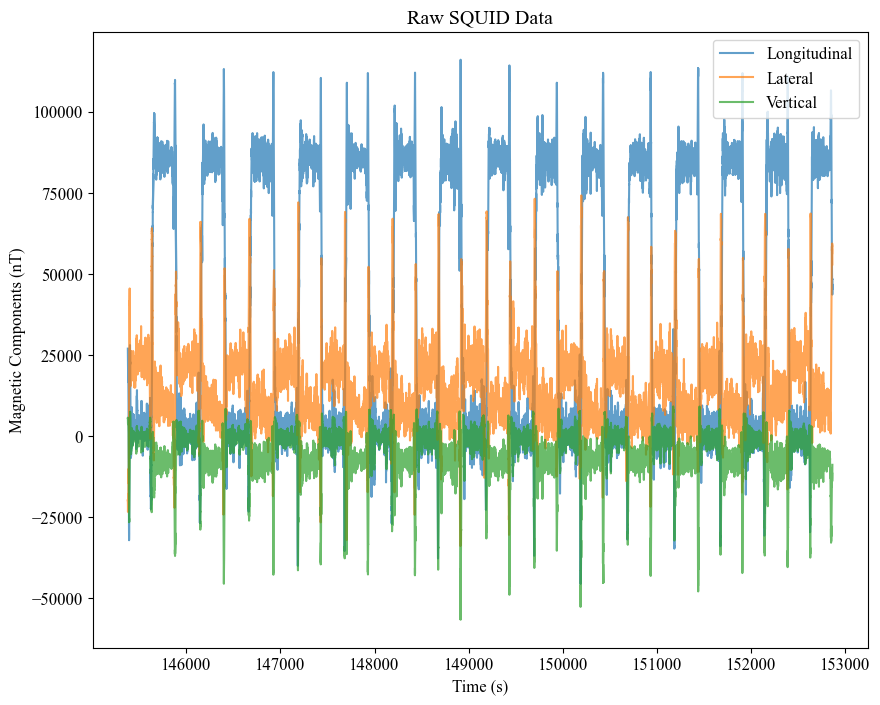

In [3]:
full_squid_time = np.load(os.path.join(path_to_data, 'full_squid_time.npy'))
full_squid = np.load(os.path.join(path_to_data, 'full_squid.npy'))
flight_start_squid = np.load(os.path.join(path_to_data, 'flight_start_squid.npy'))
flight_end_squid = np.load(os.path.join(path_to_data, 'flight_end_squid.npy'))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(9, 9)
ax = fig.add_subplot(gs[:])
ax.plot(full_squid_time[flight_start_squid:flight_end_squid:100],
        full_squid[flight_start_squid:flight_end_squid:100, 0],
        alpha=0.7, label='Longitudinal')
ax.plot(full_squid_time[flight_start_squid:flight_end_squid:100],
        full_squid[flight_start_squid:flight_end_squid:100, 1],
        alpha=0.7, label='Lateral')
ax.plot(full_squid_time[flight_start_squid:flight_end_squid:100],
        full_squid[flight_start_squid:flight_end_squid:100, 2],
        alpha=0.7, label='Vertical')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Magnetic Components (nT)')
ax.set_title('Raw SQUID Data')
ax.legend(loc='upper right')
plt.show()

### Quaternions

The next step in this chain is to determine the quaternions based on the VQF method (exactly as shown for the Namibia dataset).
As seen in that step however, the quaternions do not really give a good intuitive feeling for what is happening, so we look at the Euler angles instead.

Text(0.5, 0, 'Time (s)')

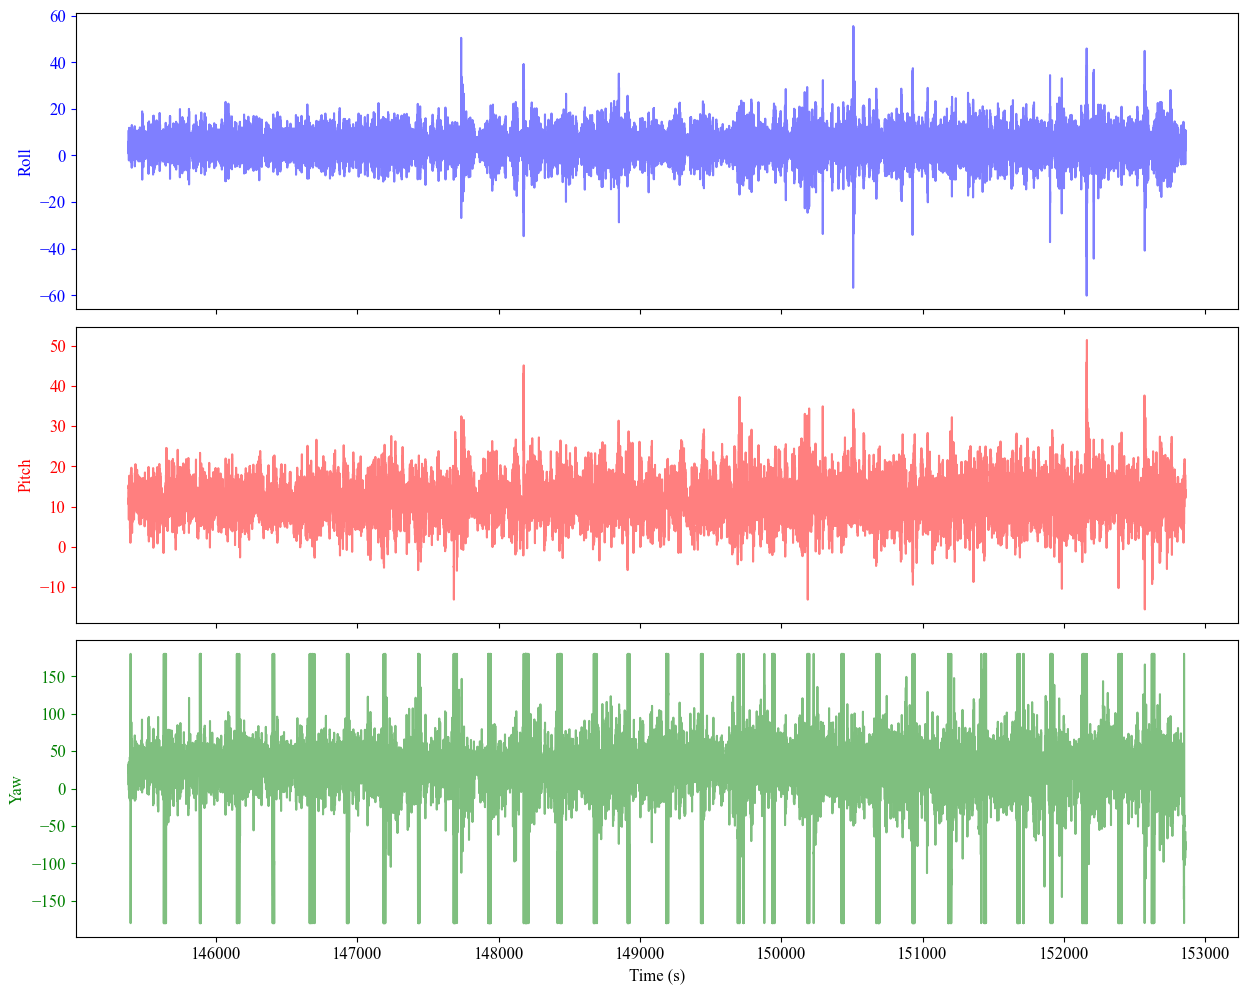

In [5]:
uimu_time = np.load(os.path.join(path_to_data, 'uimu_time.npy'))
flight_start_imu = np.load(os.path.join(path_to_data, 'flight_start_imu.npy'))
flight_end_imu = np.load(os.path.join(path_to_data, 'flight_end_imu.npy'))
euler_angles_imu = np.load(os.path.join(path_to_data, 'euler_angles_imu.npy'))
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax1 = fig.add_subplot(gs[:3, :])
ax2 = fig.add_subplot(gs[3:6, :], sharex=ax1)
ax3 = fig.add_subplot(gs[6:, :], sharex=ax1)
ax1.plot(uimu_time[flight_start_imu:flight_end_imu], np.rad2deg(euler_angles_imu[:, 0]), 'b', alpha=0.5)
ax2.plot(uimu_time[flight_start_imu:flight_end_imu], np.rad2deg(euler_angles_imu[:, 1]), 'r', alpha=0.5)
ax3.plot(uimu_time[flight_start_imu:flight_end_imu], np.rad2deg(euler_angles_imu[:, 2]), 'g', alpha=0.5)
ax1.tick_params(axis='y', colors='b')
ax1.tick_params(labelbottom=False)
ax1.set_ylabel('Roll', color='b')
ax2.tick_params(axis='y', colors='r')
ax2.tick_params(labelbottom=False)
ax2.set_ylabel('Pitch', color='r')
ax3.tick_params(axis='y', colors='g')
ax3.set_ylabel('Yaw', color='g')
ax3.set_xlabel('Time (s)')

As can be seen in this data, the heading does not really resemble flight lines.
In the case where no fluxgate is provided, there is an unknown drift in the heading and the VQF method makes zero attempts to correct for it.
In the case of Safford and Ivanhoe, the fluxgate measurements were corrupted/unusable.
This is the reason for the RTK Lib override for heading determination.

### RTK Heading

The RTK solution has slightly different locations than those given in the raw GPS file.
This step involves finding the tangents to the RTK Lib solution for latitude and longitude and using that as the heading.

The main issue with this is that it generates a lot of outliers, jumps in the data that should not be there.
This is the first place where the Lowess filter is applied.
Note that there are still points where there are rapid oscillations.
This results in more outliers in later steps, which must also be removed.
The code below plots the original and smoothed data.
It should also be noted that the use of ```numpy.unwrap``` is very much not advised at this point.

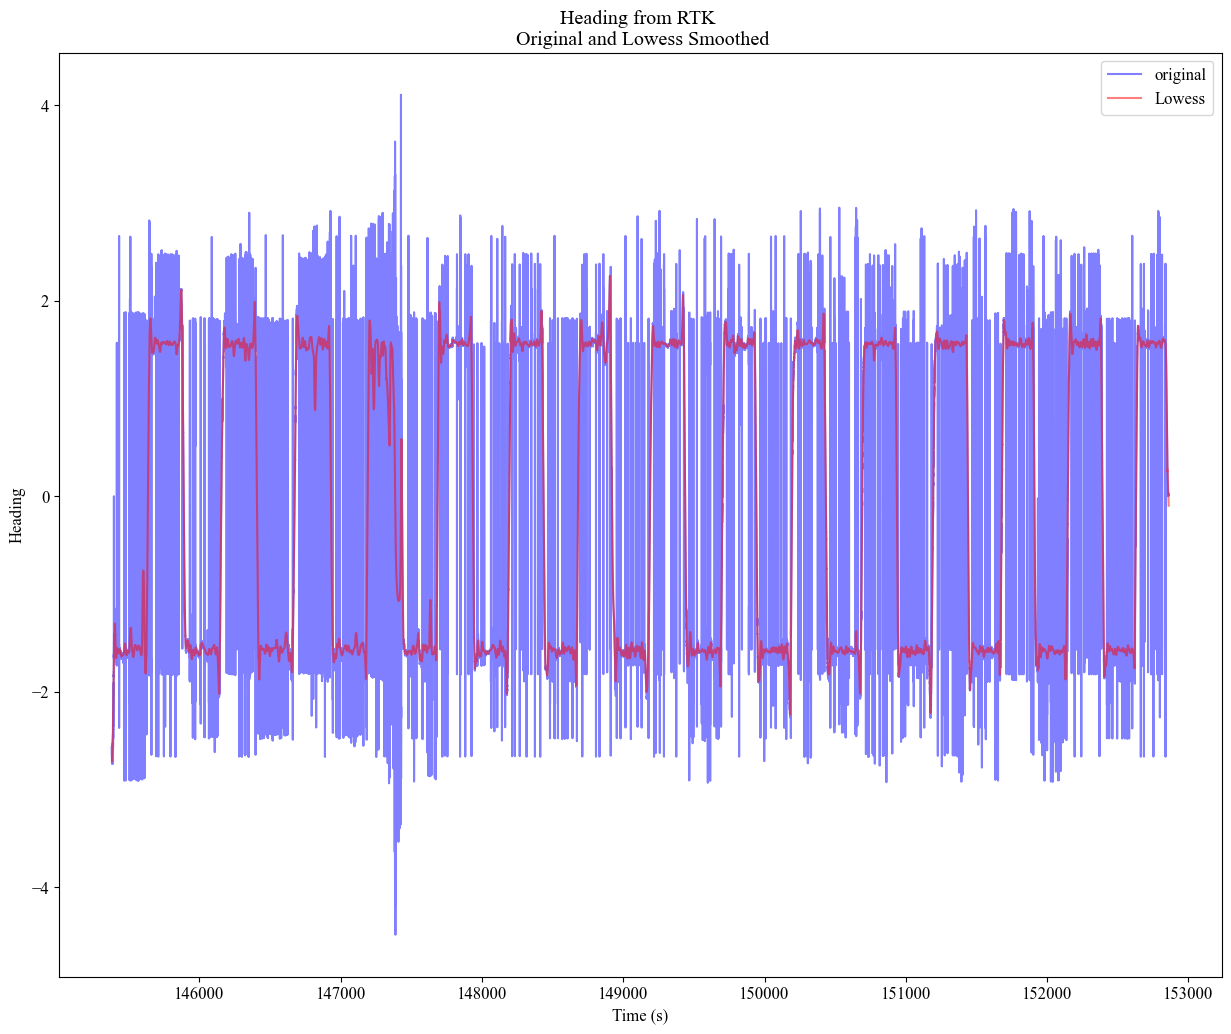

In [8]:
uimu_time = np.load(os.path.join(path_to_data, 'uimu_time.npy'))
flight_start_imu = np.load(os.path.join(path_to_data, 'flight_start_imu.npy'))
flight_end_imu = np.load(os.path.join(path_to_data, 'flight_end_imu.npy'))
rtk_heading_w_outliers = np.load(os.path.join(path_to_data, 'rtk_heading_imu_w_outliers.npy'))
rtk_heading_imu = np.load(os.path.join(path_to_data, 'rtk_heading_imu.npy'))
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax1 = fig.add_subplot(gs[:, :])
ax1.plot(uimu_time[flight_start_imu:flight_end_imu], rtk_heading_w_outliers, 'b-', alpha=0.5, label='original')
ax1.plot(uimu_time[flight_start_imu:flight_end_imu], rtk_heading_imu, 'r-', alpha=0.5, label='Lowess')
ax1.set_ylabel('Heading')
ax1.set_xlabel('Time (s)')
ax1.set_title('Heading from RTK \n Original and Lowess Smoothed')
ax1.legend(loc='upper right')

### IGRF in Body Frame

The quaternions that would normally be used in the solution are rotated around the z-axis such that the heading of the quaternions matches that of the RTK solution.
This is then interpolated to the SQUID data times, and used with the IGRF reference to get the reference into the bird body frame, at the same times as the SQUID data.
This is shown in the plot below.

Text(0.5, 1.0, 'IGRF in the Bird Body Frame')

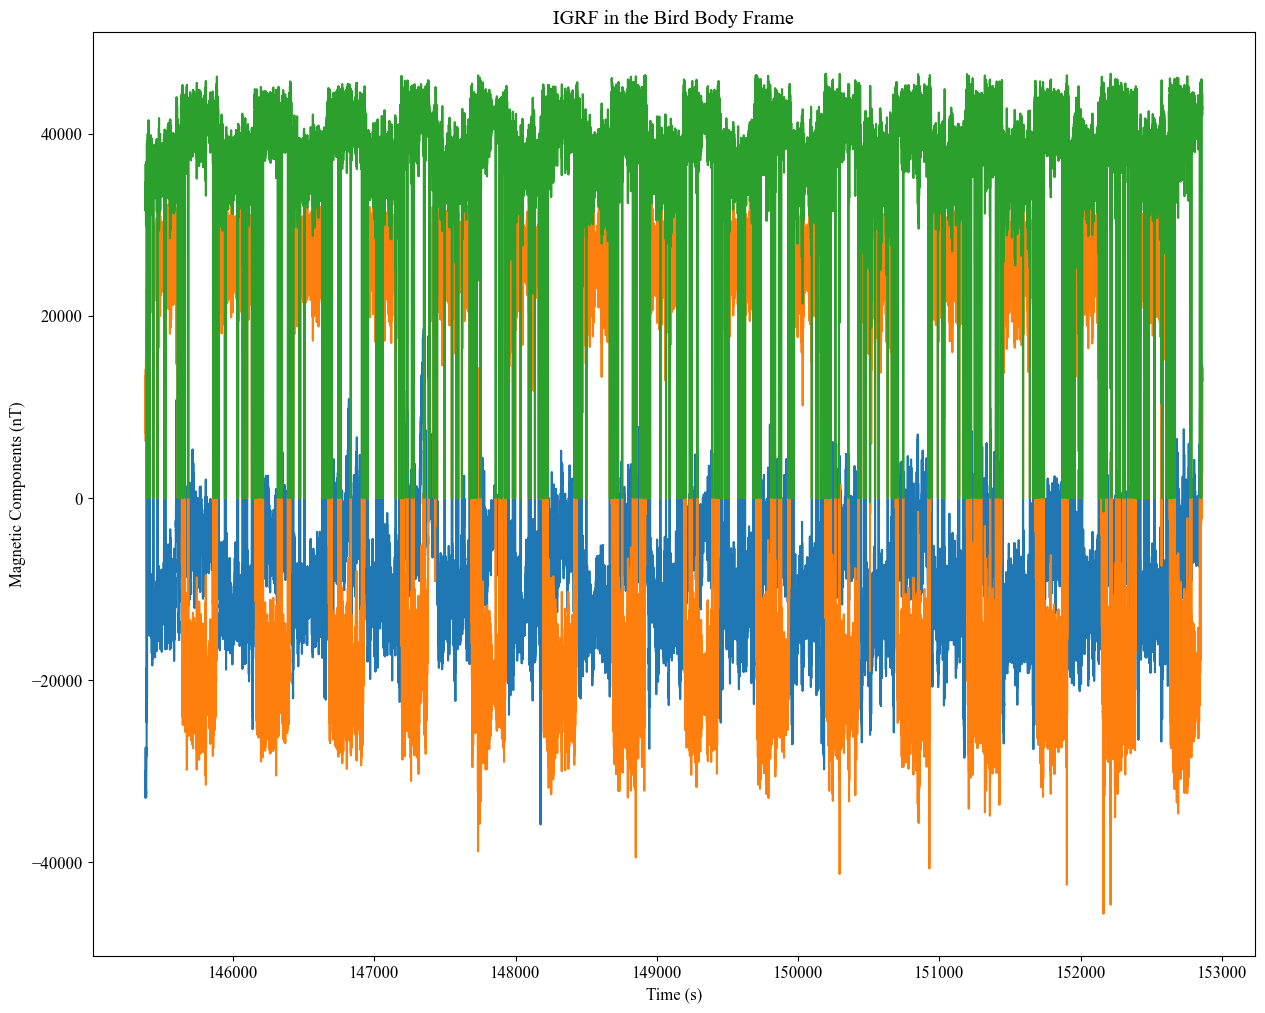

In [9]:
full_squid_time = np.load(os.path.join(path_to_data, 'full_squid_time.npy'))
flight_start_squid = np.load(os.path.join(path_to_data, 'flight_start_squid.npy'))
flight_end_squid = np.load(os.path.join(path_to_data, 'flight_end_squid.npy'))
igrf_bird_frame_no_smoothing = np.load(os.path.join(path_to_data, 'igrf_bird_frame_no_smoothing.npy'))
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax1 = fig.add_subplot(gs[:, :])
ax1.plot(full_squid_time[flight_start_squid:flight_end_squid], igrf_bird_frame_no_smoothing[:, 0], label='Longitudinal')
ax1.plot(full_squid_time[flight_start_squid:flight_end_squid], igrf_bird_frame_no_smoothing[:, 1], label='Lateral')
ax1.plot(full_squid_time[flight_start_squid:flight_end_squid], igrf_bird_frame_no_smoothing[:, 2], label='Verical')
ax1.set_ylabel('Magnetic Components (nT)')
ax1.set_xlabel('Time (s)')
ax1.set_title('IGRF in the Bird Body Frame')

This figure shows we still have outliers.
A Lowess filter is once again used to remove these points, which takes a very long time given the number of points in these time series:

Text(0.5, 1.0, 'IGRF in the Bird Body Frame \n After Lowess')

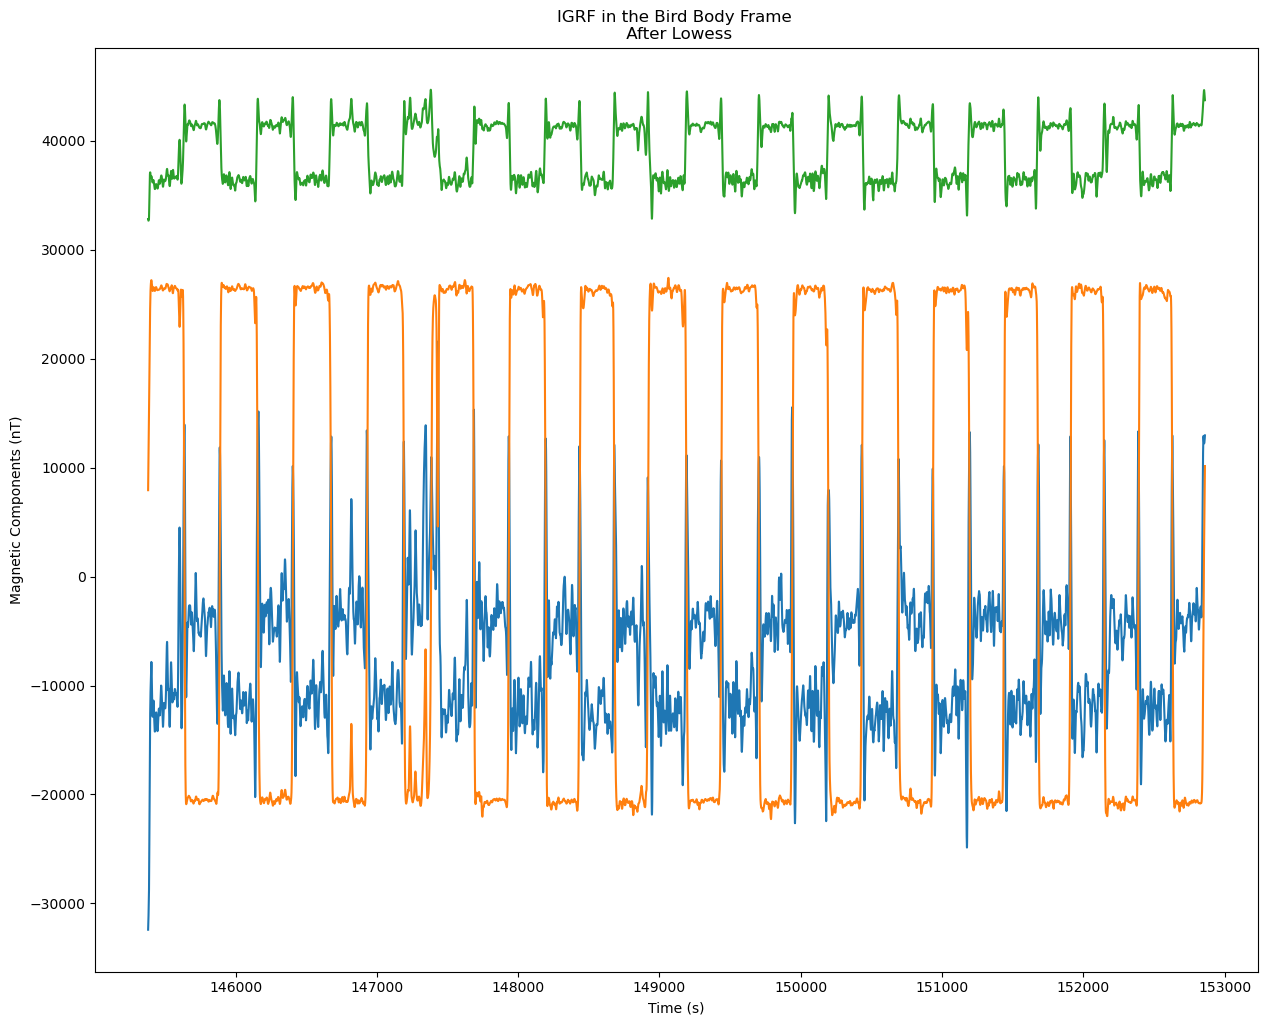

In [3]:
full_squid_time = np.load(os.path.join(path_to_data, 'full_squid_time.npy'))
flight_start_squid = np.load(os.path.join(path_to_data, 'flight_start_squid.npy'))
flight_end_squid = np.load(os.path.join(path_to_data, 'flight_end_squid.npy'))
igrf_bird_frame = np.load(os.path.join(path_to_data, 'igrf_bird_frame.npy'))
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax1 = fig.add_subplot(gs[:, :])
ax1.plot(full_squid_time[flight_start_squid:flight_end_squid], igrf_bird_frame[:, 0], label='Longitudinal')
ax1.plot(full_squid_time[flight_start_squid:flight_end_squid], igrf_bird_frame[:, 1], label='Lateral')
ax1.plot(full_squid_time[flight_start_squid:flight_end_squid], igrf_bird_frame[:, 2], label='Verical')
ax1.set_ylabel('Magnetic Components (nT)')
ax1.set_xlabel('Time (s)')
ax1.set_title('IGRF in the Bird Body Frame \n After Lowess')

This gives a more reasonable result, but might be perhaps too much? More fine tuning is needed, but takes a long time on the full dataset. 
At present, I am reducing my analysis on my machine to two lines.
In the case where this is all we wish to do, the Procrustes analysis is applied to the SQUID data, and then the SQUID data is rotated to North-East-Down convention with the quaternion:


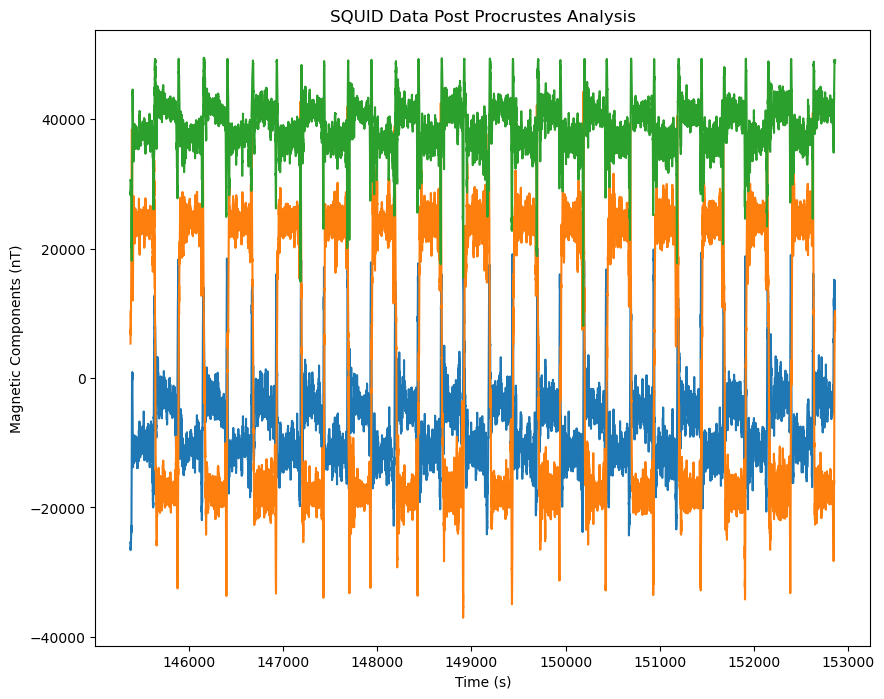

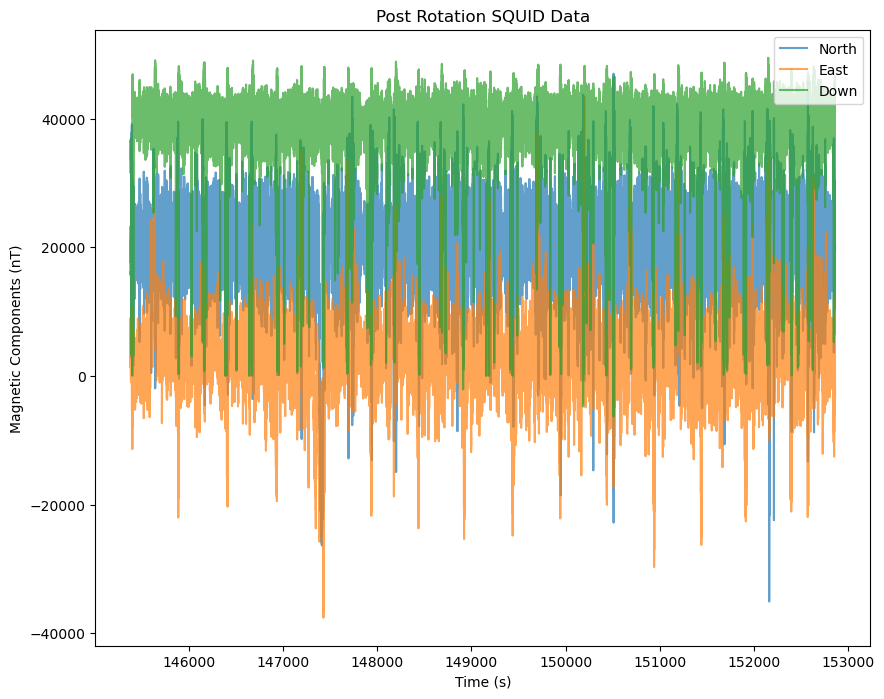

In [4]:
full_squid_time = np.load(os.path.join(path_to_data, 'full_squid_time.npy'))
flight_start_squid = np.load(os.path.join(path_to_data, 'flight_start_squid.npy'))
flight_end_squid = np.load(os.path.join(path_to_data, 'flight_end_squid.npy'))
squid_post_procrustes = np.load(os.path.join(path_to_data, 'squid_post_procrustes.npy'))
rotated_squid_data = np.load(os.path.join(path_to_data, 'rotated_squid_data.npy'))
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(9, 9)
ax1 = fig.add_subplot(gs[:, :])
ax1.plot(full_squid_time[flight_start_squid:flight_end_squid], squid_post_procrustes[flight_start_squid:flight_end_squid, 0], label='Longitudinal')
ax1.plot(full_squid_time[flight_start_squid:flight_end_squid], squid_post_procrustes[flight_start_squid:flight_end_squid, 1], label='Lateral')
ax1.plot(full_squid_time[flight_start_squid:flight_end_squid], squid_post_procrustes[flight_start_squid:flight_end_squid, 2], label='Verical')
ax1.set_ylabel('Magnetic Components (nT)')
ax1.set_xlabel('Time (s)')
ax1.set_title('SQUID Data Post Procrustes Analysis')

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(9, 9)
ax = fig.add_subplot(gs[:])
ax.plot(full_squid_time[flight_start_squid:flight_end_squid:100],
        rotated_squid_data[::100, 0],
        alpha=0.7, label='North')
ax.plot(full_squid_time[flight_start_squid:flight_end_squid:100],
        rotated_squid_data[::100, 1],
        alpha=0.7, label='East')
ax.plot(full_squid_time[flight_start_squid:flight_end_squid:100],
        rotated_squid_data[::100, 2],
        alpha=0.7, label='Down')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Magnetic Components (nT)')
ax.set_title('Post Rotation SQUID Data')
ax.legend(loc='upper right')

This is the result in the case where we do not do any of Supracon's "motion noise compensation".
The result is clearly unacceptable, even if there are no major "outliers" and the data has been corrected to the point of no longer showing the flight lines, the amount of noise and variation is clearly too much and further steps are necessary.

It can also be seen that there appear to be issues remaining in the areas where we are turning around.
The cause of this is still being investigated.

### RTK Veloctiy

The RTK Lib solution for velocity is the next step. 
This will be the velocity used in the Supracon motion noise compensation step.
Below is the RTK velocity.

Note that only the first 2 million points are used here to save RAM.

Text(0, 0.5, 'Velocity (m/s)')

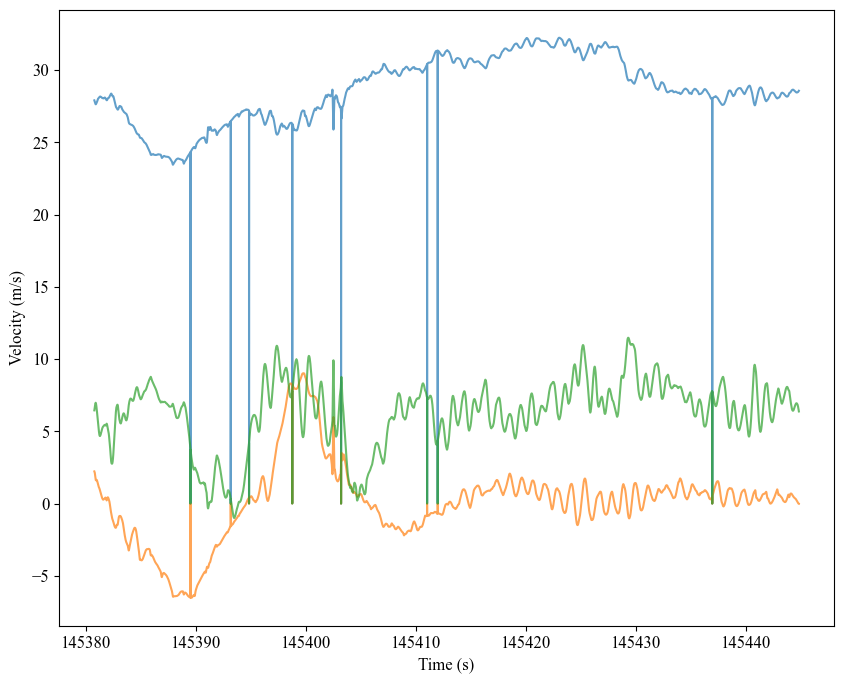

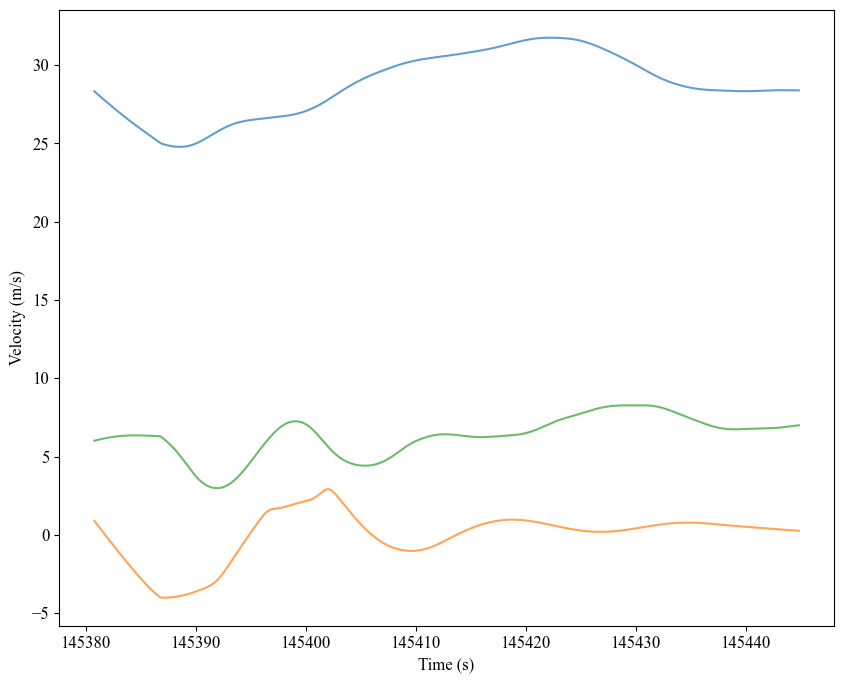

In [8]:
full_squid_time = np.load(os.path.join(path_to_data, 'full_squid_time.npy'))
flight_start_squid = np.load(os.path.join(path_to_data, 'flight_start_squid.npy'))
flight_end_squid = np.load(os.path.join(path_to_data, 'flight_end_squid.npy'))
rtk_vel_in_bird_frame = np.load(os.path.join(path_to_data, 'rtk_vel_in_bird_frame.npy'))
vel_in_bird_frame = np.load(os.path.join(path_to_data, 'vel_in_bird_frame.npy'))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(9, 9)
ax = fig.add_subplot(gs[:])
ax.plot(full_squid_time[flight_start_squid:flight_start_squid+2000000],
        rtk_vel_in_bird_frame[:2000000, 0],
        alpha=0.7, label='North')
ax.plot(full_squid_time[flight_start_squid:flight_start_squid+2000000],
        rtk_vel_in_bird_frame[:2000000, 1],
        alpha=0.7, label='East')
ax.plot(full_squid_time[flight_start_squid:flight_start_squid+2000000],
        rtk_vel_in_bird_frame[:2000000, 2],
        alpha=0.7, label='Down')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(9, 9)
ax = fig.add_subplot(gs[:])
ax.plot(full_squid_time[flight_start_squid:flight_start_squid+2000000],
        vel_in_bird_frame[:2000000, 0],
        alpha=0.7, label='North')
ax.plot(full_squid_time[flight_start_squid:flight_start_squid+2000000],
        vel_in_bird_frame[:2000000, 1],
        alpha=0.7, label='East')
ax.plot(full_squid_time[flight_start_squid:flight_start_squid+2000000],
        vel_in_bird_frame[:2000000, 2],
        alpha=0.7, label='Down')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')

This yields a problem again, as we see outliers, and Lowess is applied.
In this case, the Lowess parameters are likely too extreme and more investigation is needed.

A cross product between the velocity (in bird frame) and IGRF (in bird frame) is a necessary parameter in the motion noise compensation.
It should be noted that the version that has "no smoothing" is the version that uses the smoothed velocity and the smoothed IGRF.
This is shown below:

Text(0, 0.5, 'Velocity cross IGRF (m * nT/s)')

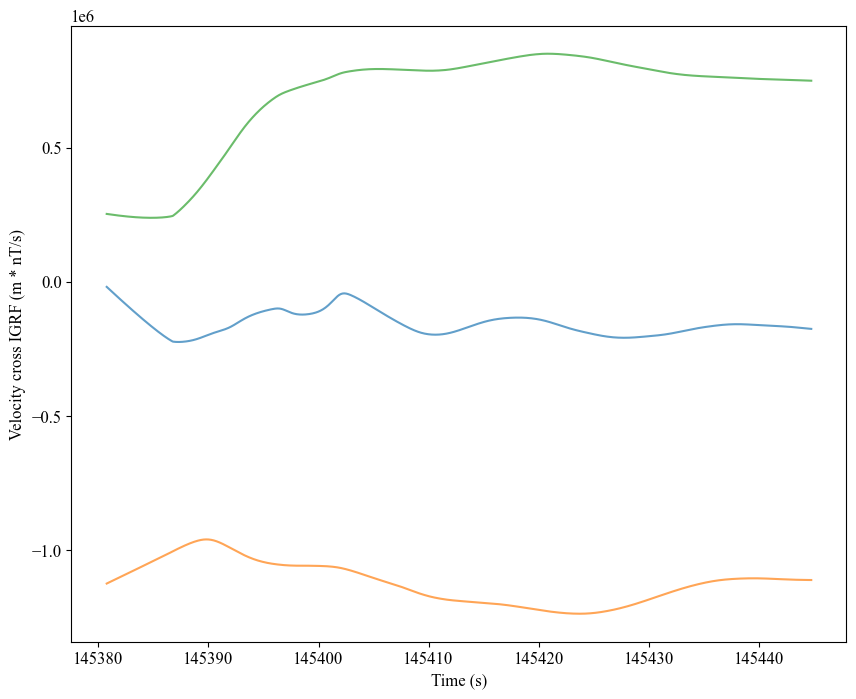

In [2]:
full_squid_time = np.load(os.path.join(path_to_data, 'full_squid_time.npy'))
flight_start_squid = np.load(os.path.join(path_to_data, 'flight_start_squid.npy'))
flight_end_squid = np.load(os.path.join(path_to_data, 'flight_end_squid.npy'))
vel_cross_igrf_bird_no_smoothing = np.load(os.path.join(path_to_data, 'vel_cross_igrf_bird_no_smoothing.npy'))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(9, 9)
ax = fig.add_subplot(gs[:])
ax.plot(full_squid_time[flight_start_squid:flight_start_squid+2000000],
        vel_cross_igrf_bird_no_smoothing[:2000000, 0],
        alpha=0.7, label='North')
ax.plot(full_squid_time[flight_start_squid:flight_start_squid+2000000],
        vel_cross_igrf_bird_no_smoothing[:2000000, 1],
        alpha=0.7, label='East')
ax.plot(full_squid_time[flight_start_squid:flight_start_squid+2000000],
        vel_cross_igrf_bird_no_smoothing[:2000000, 2],
        alpha=0.7, label='Down')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity cross IGRF (m * nT/s)')

At present, I have not done a full Supracon motion noise compensation on the full dataset. I am currently working on results for two lines, but it does not look as though it works. Investigation is ongoing.